<a href="https://colab.research.google.com/github/miltiadiss/CEID_NE577-5G-Architectures-Technologies-Applications-and-Key-Performance-Indexes/blob/main/Code/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from math import sqrt

# **LSTM**


Training LSTM with time_steps = 32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


815/815 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step
 Validation RMSE: 4291.6209

Training LSTM with time_steps = 64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


814/814 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step
 Validation RMSE: 4272.2761

Training LSTM with time_steps = 96


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


814/814 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step
 Validation RMSE: 4203.8529

Training LSTM with time_steps = 128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


814/814 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step
 Validation RMSE: 4163.7155


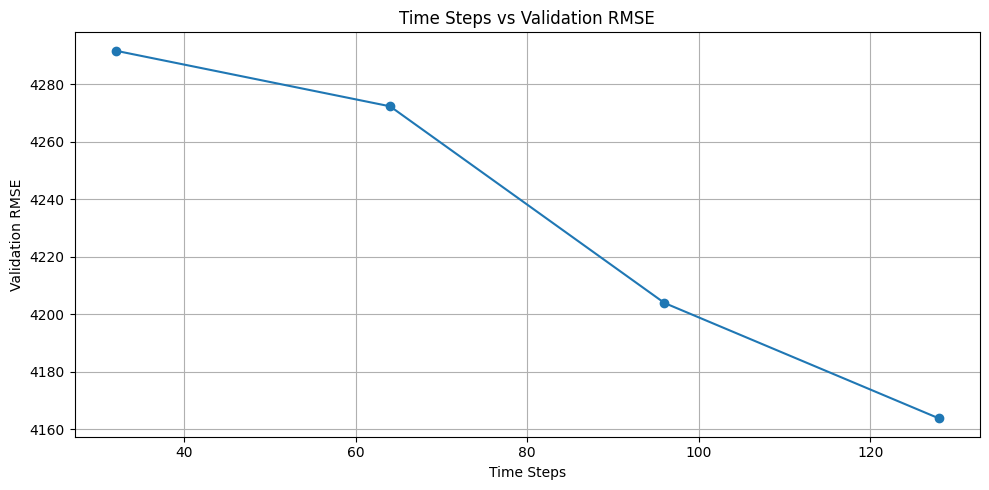

In [ ]:
#  Δημιουργία time-series windows
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

#  Φόρτωση dataset
df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv")
target = "DL_bitrate"
features = df.drop(columns=[target])
target = df[target]

#  Κανονικοποίηση
feature_scaler = StandardScaler()
features_scaled = pd.DataFrame(feature_scaler.fit_transform(features), columns=features.columns, index=features.index)

target_scaler = StandardScaler()
target_scaled = pd.Series(target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten(), index=target.index)

#  Time steps που θα δοκιμαστούν
time_steps_list = [32, 64, 96]
val_rmse_list = []

best_rmse = float('inf')
best_model_info = {}

for ts in time_steps_list:
    print(f"\nTraining LSTM with time_steps = {ts}")

    # Δημιουργία παραθύρων
    X, y = create_dataset(features_scaled, target_scaled, ts)

    # Διαχωρισμός σε train, val, test (70%, 15%, 15%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

    # Ορισμός LSTM μοντέλου
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=0
    )

    # Υπολογισμός RMSE στο validation
    y_val_pred = model.predict(X_val)
    y_val_orig = target_scaler.inverse_transform(y_val.reshape(-1, 1))
    y_val_pred_orig = target_scaler.inverse_transform(y_val_pred)
    val_rmse = sqrt(mean_squared_error(y_val_orig, y_val_pred_orig))
    val_rmse_list.append(val_rmse)

    print(f" Validation RMSE: {val_rmse:.4f}")

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model_info = {
            "model": model,
            "time_steps": ts,
            "X_train": X_train,
            "y_train": y_train,
            "X_val": X_val,
            "y_val": y_val,
            "X_test": X_test,
            "y_test": y_test,
            "history": history
        }

# --- Γραφική: Time Steps vs Validation RMSE
plt.figure(figsize=(10, 5))
plt.plot(time_steps_list, val_rmse_list, marker='o')
plt.title("Time Steps vs Validation RMSE")
plt.xlabel("Time Steps")
plt.ylabel("Validation RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()



 Best time_steps: 128 (Validation RMSE: 4163.7155)
3797/3797 ━━━━━━━━━━━━━━━━━━━━ 133s 35ms/step
814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step
814/814 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step

Train Set Metrics:
RMSE: 3528.8862
MAE: 2099.6829

Validation Set Metrics:
RMSE: 4163.7155
MAE: 2794.0388

Test Set Metrics:
RMSE: 4611.0831
MAE: 2989.5579


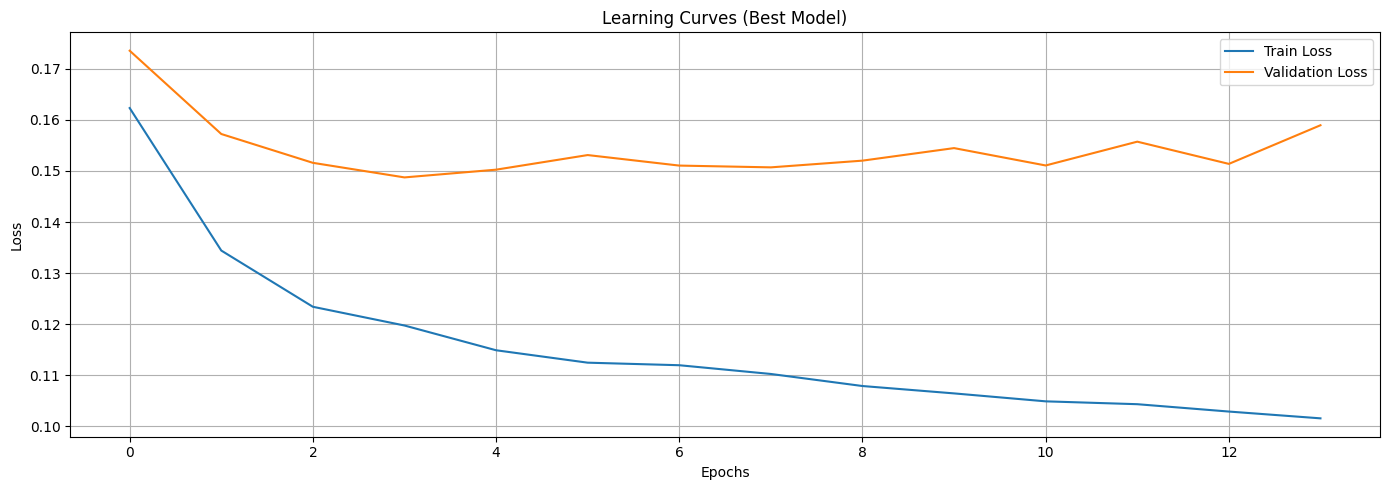

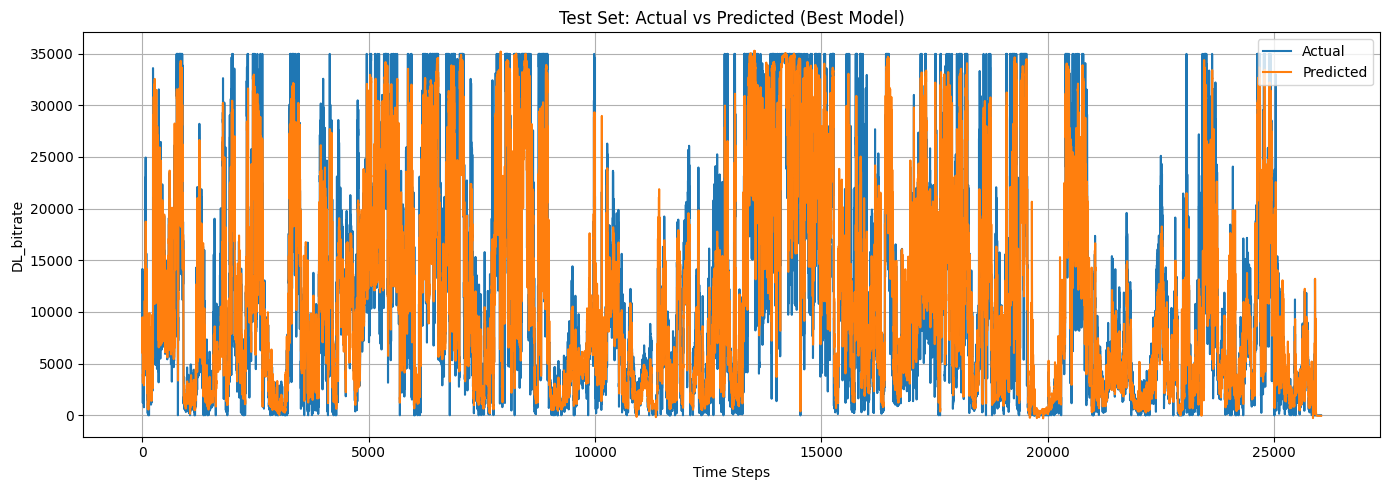

In [ ]:

#  Αξιολόγηση του καλύτερου μοντέλου
print(f"\n Best time_steps: {best_model_info['time_steps']} (Validation RMSE: {best_rmse:.4f})")

# Ανάκτηση δεδομένων & μοντέλου
model = best_model_info["model"]
history = best_model_info["history"]
X_train = best_model_info["X_train"]
y_train = best_model_info["y_train"]
X_val = best_model_info["X_val"]
y_val = best_model_info["y_val"]
X_test = best_model_info["X_test"]
y_test = best_model_info["y_test"]

# Προβλέψεις
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Αποκανονικοποίηση
y_train_orig = target_scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_orig = target_scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1))

y_train_pred_orig = target_scaler.inverse_transform(y_train_pred)
y_val_pred_orig = target_scaler.inverse_transform(y_val_pred)
y_test_pred_orig = target_scaler.inverse_transform(y_test_pred)

# Συνάρτηση υπολογισμού μετρικών
def print_metrics(name, true, pred):
    mse = mean_squared_error(true, pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(true, pred)
    print(f"\n{name} Set Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

#  Εκτύπωση μετρικών
print_metrics("Train", y_train_orig, y_train_pred_orig)
print_metrics("Validation", y_val_orig, y_val_pred_orig)
print_metrics("Test", y_test_orig, y_test_pred_orig)

#  Learning Curves
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Learning Curves (Best Model)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Actual vs Predicted (Test Set)
plt.figure(figsize=(14, 5))
plt.plot(y_test_orig, label='Actual')
plt.plot(y_test_pred_orig, label='Predicted')
plt.title("Test Set: Actual vs Predicted (Best Model)")
plt.xlabel("Time Steps")
plt.ylabel("DL_bitrate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**We calculate for better understanding the percentages of the error metrics to see how far the predictions are from the average actual DL_bitrate of the test data.**

In [ ]:
# Υπολογισμός της μέσης πραγματικής τιμής του test set
mean_actual_value = y_test_orig.mean()
print(f"Μέση πραγματική τιμή στο Test Set: {mean_actual_value:.4f}")

# Υπολογισμός σφαλμάτων
rmse = sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))
mae = mean_absolute_error(y_test_orig, y_test_pred_orig)

# Σφάλματα ως ποσοστό της μέσης τιμής
rmse_pct = (rmse / mean_actual_value) * 100
mae_pct = (mae / mean_actual_value) * 100

print(f"\nΣφάλματα ως ποσοστό της μέσης τιμής:")
print(f"RMSE (%): {rmse_pct:.2f}%")
print(f"MAE  (%): {mae_pct:.2f}%")


Μέση πραγματική τιμή στο Test Set: 11627.1222

Σφάλματα ως ποσοστό της μέσης τιμής:
RMSE (%): 39.66%
MAE  (%): 25.71%


814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step
Feature: Speed, RMSE Δ: -20.7996
814/814 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step
Feature: RSRP, RMSE Δ: 194.5320
814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step
Feature: RSRQ, RMSE Δ: 125.5084
814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step
Feature: SNR, RMSE Δ: 110.8154
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step
Feature: CQI, RMSE Δ: 141.0700
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step
Feature: RSSI, RMSE Δ: 98.1298
814/814 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step
Feature: UL_bitrate, RMSE Δ: 8442.2609
814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step
Feature: NRxRSRP, RMSE Δ: -29.2678
814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step
Feature: NRxRSRQ, RMSE Δ: 16.7846
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step
Feature: ServingCell_Distance, RMSE Δ: 342.4261
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step
Feature: Categorical_Impact, RMSE Δ: 514.7806


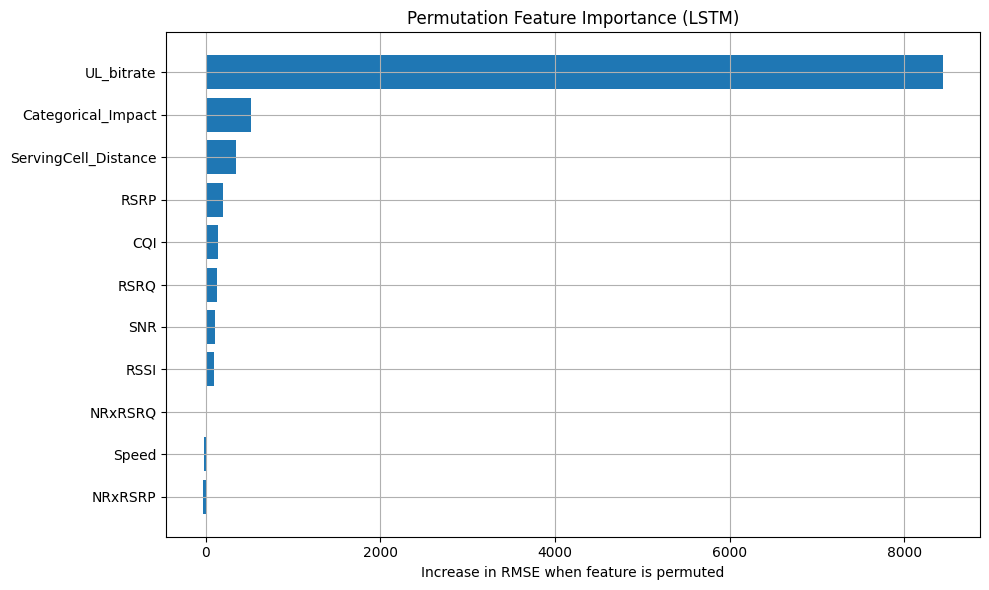

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

#  προβλέψεις για το Test set
baseline_rmse = sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))

feature_names = features_scaled.columns.tolist()
num_features = len(feature_names)
importances = []

# Για κάθε χαρακτηριστικό: κάνε permute και υπολόγισε νέο RMSE
for i in range(num_features):
    X_test_permuted = X_test.copy()

    # κάνε shuffle μόνο στο i-th feature σε ολα τα time steps
    X_test_permuted[:, :, i] = np.random.permutation(X_test_permuted[:, :, i])

    # πρόβλεψη με το permuted test set
    y_pred_perm = model.predict(X_test_permuted)
    y_pred_perm_orig = target_scaler.inverse_transform(y_pred_perm)

    perm_rmse = sqrt(mean_squared_error(y_test_orig, y_pred_perm_orig))
    delta = perm_rmse - baseline_rmse
    importances.append(delta)

    print(f"Feature: {feature_names[i]}, RMSE Δ: {delta:.4f}")

# Μετατροπή σε DataFrame για plotting
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance (RMSE Δ)": importances
}).sort_values(by="Importance (RMSE Δ)", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance (RMSE Δ)"])
plt.xlabel("Increase in RMSE when feature is permuted")
plt.title("Permutation Feature Importance (LSTM)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()
# --- Scatter plot: Feature Rank vs RMSE Δ
plt.figure(figsize=(8, 5))
plt.scatter(range(len(importance_df)), importance_df["Importance (RMSE Δ)"], color='dodgerblue')
plt.title("Κατανομή σημασίας χαρακτηριστικών (RMSE Δ)")
plt.xlabel("Κατάταξη χαρακτηριστικού")
plt.ylabel("Αύξηση RMSE όταν γίνεται permute")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Cumulative Importance plot
importance_df["Cumulative Importance"] = importance_df["Importance (RMSE Δ)"].cumsum()
total = importance_df["Importance (RMSE Δ)"].sum()
importance_df["Cumulative %"] = 100 * importance_df["Cumulative Importance"] / total

plt.figure(figsize=(10, 5))
plt.plot(range(len(importance_df)), importance_df["Cumulative %"], marker='o', color='darkgreen')
plt.axhline(y=90, color='red', linestyle='--', label="90% threshold")
plt.title("Συσσώρευση σημασίας χαρακτηριστικών")
plt.xlabel("Κατάταξη χαρακτηριστικού")
plt.ylabel("Συσσωρευμένο ποσοστό σημασίας (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# --- Πάρε τα χαρακτηριστικά ταξινομημένα κατά σημασία
sorted_features = importance_df["Feature"].tolist()

# --- Βασικές ρυθμίσεις
TIME_STEPS = 128
batch_size = 32
epochs = 50
patience = 10
step = 10  # μειώνουμε ανά 10 χαρακτηριστικά

results = []

for i in range(0, len(sorted_features), step):
    selected_features = sorted_features[:len(sorted_features)-i]
    if len(selected_features) < 1:
        break

    df_selected = df[selected_features]

    # Κανονικοποίηση
    scaler_X = StandardScaler()
    df_scaled = pd.DataFrame(scaler_X.fit_transform(df_selected), columns=selected_features, index=df.index)

    # Δημιουργία time windows
    X_all, y_all = create_dataset(df_scaled, target_scaled, TIME_STEPS)

    # Διαχωρισμός σε train/val/test
    X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.3, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

    # LSTM μοντέλο
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stop],
              verbose=0)

    # Προβλέψεις
    y_test_pred = model.predict(X_test)
    y_test_orig_denorm = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    y_test_pred_denorm = target_scaler.inverse_transform(y_test_pred)

    # Μετρικές
    rmse = sqrt(mean_squared_error(y_test_orig_denorm, y_test_pred_denorm))
    mae = mean_absolute_error(y_test_orig_denorm, y_test_pred_denorm)
    mse = mean_squared_error(y_test_orig_denorm, y_test_pred_denorm)

    results.append({
        "Remaining Features": len(selected_features),
        "RMSE": rmse,
        "MAE": mae,
        "MSE": mse
    })

    print(f" Χαρακτηριστικά: {len(selected_features)} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")

# --- DataFrame αποτελεσμάτων
results_df = pd.DataFrame(results)

# --- Αποθήκευση
results_df.to_csv("lstm_feature_selection_results.csv", index=False)

# --- Γραφική
plt.figure(figsize=(10, 6))
plt.plot(results_df["Remaining Features"], results_df["RMSE"], label="RMSE", marker='o')
plt.plot(results_df["Remaining Features"], results_df["MAE"], label="MAE", marker='s')
plt.plot(results_df["Remaining Features"], results_df["MSE"], label="MSE", marker='^')
plt.xlabel("Αριθμός χαρακτηριστικών")
plt.ylabel("Σφάλμα")
plt.title("Απόδοση LSTM vs αριθμός χαρακτηριστικών (Permutation-based αφαίρεση)")
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'importance_df' is not defined

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 718s 375ms/step - loss: 0.1858 - val_loss: 0.1663
Epoch 2/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 743s 391ms/step - loss: 0.1344 - val_loss: 0.1623
Epoch 3/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 798s 389ms/step - loss: 0.1268 - val_loss: 0.1593
Epoch 4/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 744s 390ms/step - loss: 0.1148 - val_loss: 0.1554
Epoch 5/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 745s 392ms/step - loss: 0.1112 - val_loss: 0.1574
Epoch 6/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 832s 408ms/step - loss: 0.1085 - val_loss: 0.1549
Epoch 7/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 767s 390ms/step - loss: 0.1049 - val_loss: 0.1523
Epoch 8/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 740s 389ms/step - loss: 0.1038 - val_loss: 0.1518
Epoch 9/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 745s 390ms/step - loss: 0.1028 - val_loss: 0.1602
Epoch 10/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 746s 393ms/step - loss: 0.1018 - val_loss: 0.1547
Epoch 11/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 800s 391ms/step - loss: 0.0983 - val

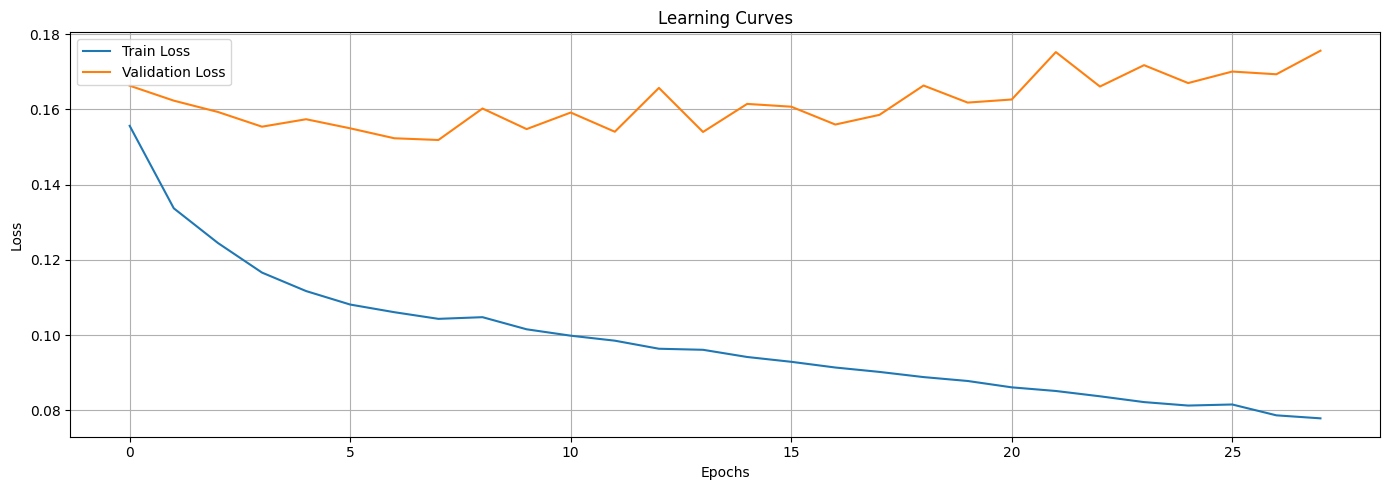

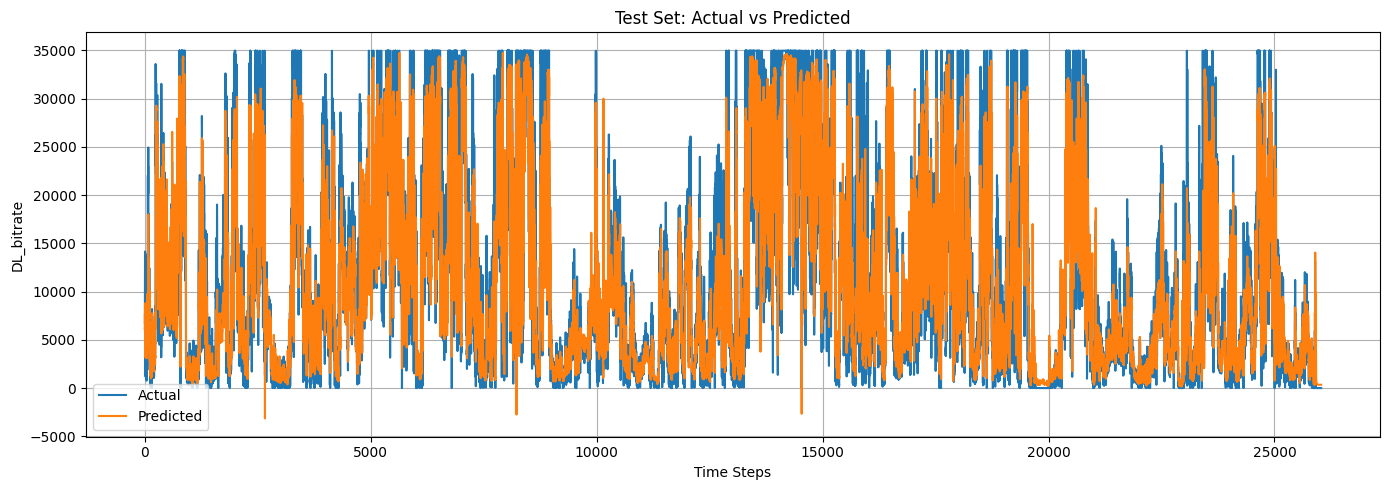

In [2]:
# Δημιουργία time-series windows
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Φόρτωση dataset
df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv")
target = "DL_bitrate"
features = df.drop(columns=[target])
target = df[target]

# Κανονικοποίηση
feature_scaler = StandardScaler()
features_scaled = pd.DataFrame(feature_scaler.fit_transform(features), columns=features.columns, index=features.index)

target_scaler = StandardScaler()
target_scaled = pd.Series(target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten(), index=target.index)

# Δημιουργία χρονικών παραθύρων
TIME_STEPS = 128
X, y = create_dataset(features_scaled, target_scaled, TIME_STEPS)

# Διαχωρισμός σε train/val/test (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Μοντέλο LSTM
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Εκπαίδευση
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Προβλέψεις για όλα τα σύνολα
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Αντιστροφή κανονικοποίησης
y_train_orig = target_scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_orig = target_scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1))

y_train_pred_orig = target_scaler.inverse_transform(y_train_pred)
y_val_pred_orig = target_scaler.inverse_transform(y_val_pred)
y_test_pred_orig = target_scaler.inverse_transform(y_test_pred)

# Υπολογισμός μετρικών
def print_metrics(name, true, pred):
    mse = mean_squared_error(true, pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(true, pred)
    print(f"\n{name} Set Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

print_metrics("Train", y_train_orig, y_train_pred_orig)
print_metrics("Validation", y_val_orig, y_val_pred_orig)
print_metrics("Test", y_test_orig, y_test_pred_orig)


# Οπτικοποίηση Learning Curves
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Learning Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Οπτικοποίηση Actual vs Predicted για Test
plt.figure(figsize=(14, 5))
plt.plot(y_test_orig, label='Actual')
plt.plot(y_test_pred_orig, label='Predicted')
plt.title("Test Set: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("DL_bitrate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()








814/814 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step
Feature: Speed, RMSE Δ: 9.5244
814/814 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step
Feature: RSRP, RMSE Δ: 94.3232
814/814 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step
Feature: RSRQ, RMSE Δ: 179.0082
814/814 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step
Feature: SNR, RMSE Δ: 163.5935
814/814 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step
Feature: CQI, RMSE Δ: 144.3535
814/814 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step
Feature: RSSI, RMSE Δ: 40.6834
814/814 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step
Feature: UL_bitrate, RMSE Δ: 8305.1817
814/814 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step
Feature: NRxRSRP, RMSE Δ: 26.8339
814/814 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step
Feature: NRxRSRQ, RMSE Δ: 58.9328
814/814 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step
Feature: ServingCell_Distance, RMSE Δ: 331.9609
814/814 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step
Feature: Categorical_Impact, RMSE Δ: 234.0781


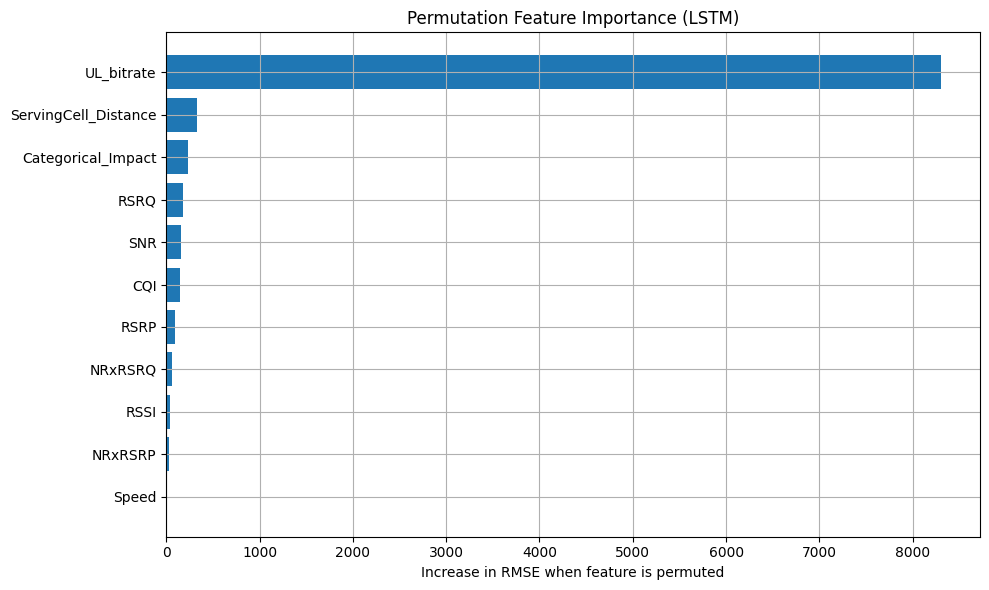

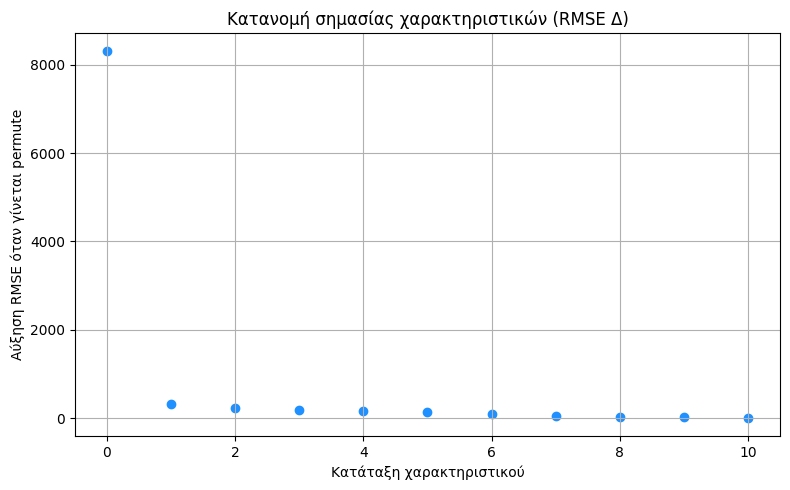

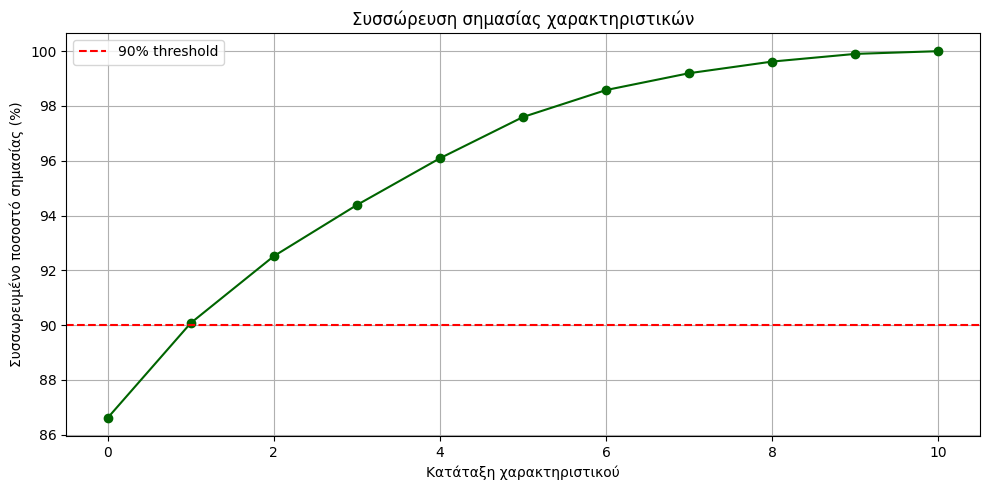

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

#  προβλέψεις για το Test set
baseline_rmse = sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))

feature_names = features_scaled.columns.tolist()
num_features = len(feature_names)
importances = []

# Για κάθε χαρακτηριστικό: κάνε permute και υπολόγισε νέο RMSE
for i in range(num_features):
    X_test_permuted = X_test.copy()

    # κάνε shuffle μόνο στο i-th feature σε ολα τα time steps
    X_test_permuted[:, :, i] = np.random.permutation(X_test_permuted[:, :, i])

    # πρόβλεψη με το permuted test set
    y_pred_perm = model.predict(X_test_permuted)
    y_pred_perm_orig = target_scaler.inverse_transform(y_pred_perm)

    perm_rmse = sqrt(mean_squared_error(y_test_orig, y_pred_perm_orig))
    delta = perm_rmse - baseline_rmse
    importances.append(delta)

    print(f"Feature: {feature_names[i]}, RMSE Δ: {delta:.4f}")

# Μετατροπή σε DataFrame για plotting
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance (RMSE Δ)": importances
}).sort_values(by="Importance (RMSE Δ)", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance (RMSE Δ)"])
plt.xlabel("Increase in RMSE when feature is permuted")
plt.title("Permutation Feature Importance (LSTM)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()
# --- Scatter plot: Feature Rank vs RMSE Δ
plt.figure(figsize=(8, 5))
plt.scatter(range(len(importance_df)), importance_df["Importance (RMSE Δ)"], color='dodgerblue')
plt.title("Κατανομή σημασίας χαρακτηριστικών (RMSE Δ)")
plt.xlabel("Κατάταξη χαρακτηριστικού")
plt.ylabel("Αύξηση RMSE όταν γίνεται permute")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Cumulative Importance plot
importance_df["Cumulative Importance"] = importance_df["Importance (RMSE Δ)"].cumsum()
total = importance_df["Importance (RMSE Δ)"].sum()
importance_df["Cumulative %"] = 100 * importance_df["Cumulative Importance"] / total

plt.figure(figsize=(10, 5))
plt.plot(range(len(importance_df)), importance_df["Cumulative %"], marker='o', color='darkgreen')
plt.axhline(y=90, color='red', linestyle='--', label="90% threshold")
plt.title("Συσσώρευση σημασίας χαρακτηριστικών")
plt.xlabel("Κατάταξη χαρακτηριστικού")
plt.ylabel("Συσσωρευμένο ποσοστό σημασίας (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [5]:
# Υπολογισμός της μέσης πραγματικής τιμής του test set
mean_actual_value = y_test_orig.mean()
print(f"Μέση πραγματική τιμή στο Test Set: {mean_actual_value:.4f}")

# Υπολογισμός σφαλμάτων
rmse = sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))
mae = mean_absolute_error(y_test_orig, y_test_pred_orig)

# Σφάλματα ως ποσοστό της μέσης τιμής
rmse_pct = (rmse / mean_actual_value) * 100
mae_pct = (mae / mean_actual_value) * 100

print(f"\nΣφάλματα ως ποσοστό της μέσης τιμής:")
print(f"RMSE (%): {rmse_pct:.2f}%")
print(f"MAE  (%): {mae_pct:.2f}%")


Μέση πραγματική τιμή στο Test Set: 11627.1222

Σφάλματα ως ποσοστό της μέσης τιμής:
RMSE (%): 39.27%
MAE  (%): 25.54%


Top-3 Features: ['UL_bitrate', 'ServingCell_Distance', 'Categorical_Impact']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 768s 403ms/step - loss: 0.1859 - val_loss: 0.1718
Epoch 2/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 756s 379ms/step - loss: 0.1485 - val_loss: 0.1785
Epoch 3/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 773s 395ms/step - loss: 0.1405 - val_loss: 0.1712
Epoch 4/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 806s 397ms/step - loss: 0.1363 - val_loss: 0.1691
Epoch 5/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 806s 399ms/step - loss: 0.1323 - val_loss: 0.1696
Epoch 6/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 800s 398ms/step - loss: 0.1327 - val_loss: 0.1681
Epoch 7/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 798s 396ms/step - loss: 0.1291 - val_loss: 0.1687
Epoch 8/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 716s 377ms/step - loss: 0.1294 - val_loss: 0.1697
Epoch 9/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 751s 396ms/step - loss: 0.1264 - val_loss: 0.1629
Epoch 10/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 765s 376ms/step - loss: 0.1266 - val_loss: 0.1678
Epoch 11/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 751s 381ms/step - loss: 0.1210 - val

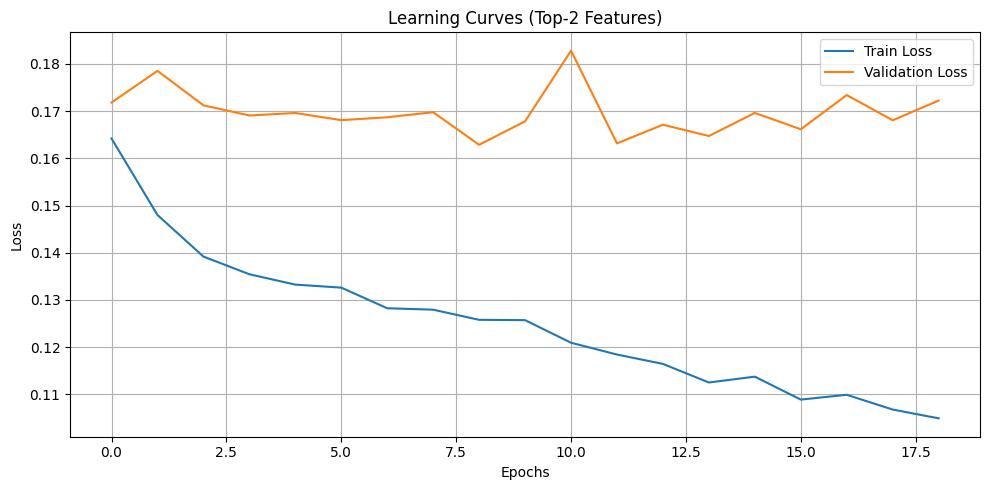

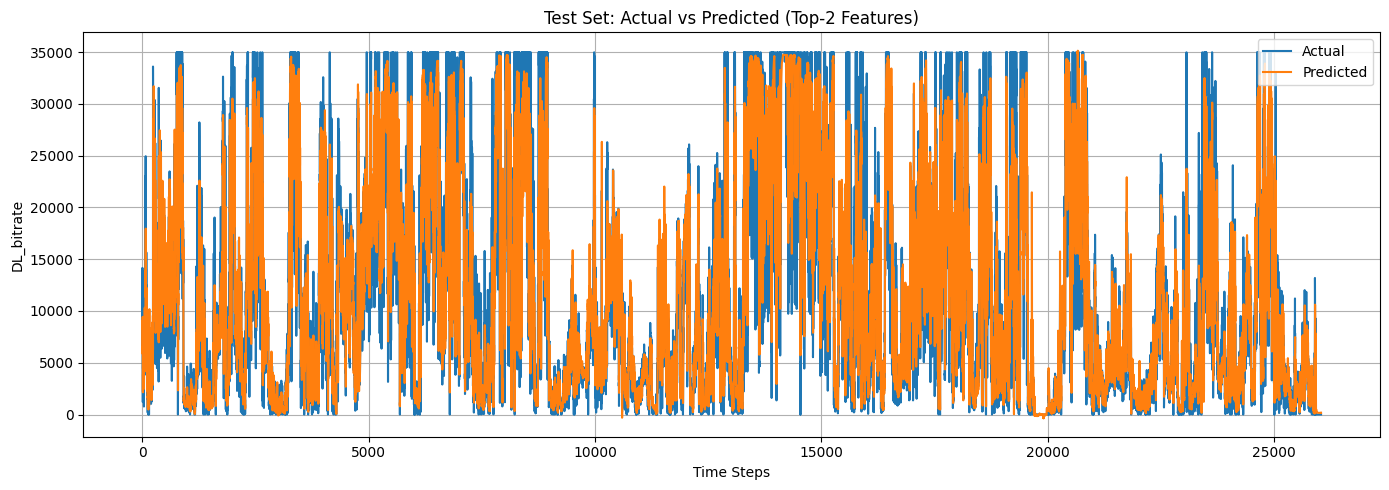

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt

# --- Top-3 χαρακτηριστικά από το importance_df
top_features = importance_df["Feature"].iloc[:3].tolist()
print("Top-3 Features:", top_features)

# --- Dataset με τα επιλεγμένα χαρακτηριστικά και το target
df_top2 = df[top_features]
target = df["DL_bitrate"]

# --- Κανονικοποίηση
scaler_X = StandardScaler()
X_scaled = pd.DataFrame(scaler_X.fit_transform(df_top2), columns=top_features, index=df.index)

scaler_y = StandardScaler()
y_scaled = pd.Series(scaler_y.fit_transform(target.values.reshape(-1, 1)).flatten(), index=df.index)

# --- Time-series windows
def create_dataset(X, y, time_steps=128):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 128
X_all, y_all = create_dataset(X_scaled, y_scaled, time_steps=TIME_STEPS)

# --- Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# --- LSTM μοντέλο
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stop],
                    verbose=1)

# --- Προβλέψεις
y_test_pred = model.predict(X_test)
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_test_pred_orig = scaler_y.inverse_transform(y_test_pred)

# --- Μετρικές
rmse = sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))
mae = mean_absolute_error(y_test_orig, y_test_pred_orig)

print("\n🎯 LSTM με Top-2 Features:")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE:  {mae:.2f}")

# --- Learning Curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curves (Top-2 Features)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Actual vs Predicted
plt.figure(figsize=(14, 5))
plt.plot(y_test_orig, label='Actual')
plt.plot(y_test_pred_orig, label='Predicted')
plt.title("Test Set: Actual vs Predicted (Top-2 Features)")
plt.xlabel("Time Steps")
plt.ylabel("DL_bitrate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
